# Lab Session 3: Applying Traditional NLP Techniques

## Objectives

By the end of this lab, you will be able to:

1. Apply traditional NLP techniques to the annotated Sierra Club press release data
2. Implement and compare different text classification methods
3. Conduct topic modeling on environmental communication texts
4. Analyze word co-occurrence patterns in press releases
5. Visualize and interpret the results of these analyses

## Installation

Before we begin, let's install the necessary packages for this lab. Run the following cell to install the required libraries:


In [ ]:
%pip install nlp4ss

## Setup and Data Loading

First, let's set up our environment and load the data from our previous lab sessions.


In [13]:
from hyfi import HyFI
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from gensim import corpora
from gensim.models import LdaModel
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings("ignore", category=DeprecationWarning)

if HyFI.is_colab():
    HyFI.mount_google_drive()
    project_root = "/content/drive/MyDrive/courses/nlp4ss"
else:
    project_root = "$HOME/workspace/courses/nlp4ss"

h = HyFI.initialize(
    project_name="nlp4ss",
    project_root=project_root,
    logging_level="WARNING",
    verbose=True,
)

# Load the data from previous lab sessions
topics_df = pd.read_csv(
    h.project.workspace_dir / "data/processed/sierra_club_topics.csv"
)
sentiment_df = pd.read_csv(
    h.project.workspace_dir / "data/processed/sierra_club_sentiment.csv"
)
issues_df = pd.read_csv(
    h.project.workspace_dir / "data/processed/sierra_club_key_issues.csv"
)

# Merge the dataframes
merged_df = pd.merge(topics_df, sentiment_df, on="content")
merged_df = pd.merge(merged_df, issues_df, on="content")

print(merged_df.head())
print(f"Number of rows: {len(merged_df)}")

INFO:hyfi.joblib.joblib:initialized batcher with <hyfi.joblib.batcher.batcher.Batcher object at 0x177910e30>


                                             content        zero_shot_topic  \
0  April 5, 2017\n\n\nContact\n Emily Pomilio (20...       Renewable Energy   
1  October 28, 2021\n\n\nContact\nShiloh Hernande...  Environmental Justice   
2  December 6, 2018\n\n\nContact\nCourtney Bourgo...  Environmental Justice   
3  Black households face disproportionately high ...  Environmental Justice   
4  February 24, 2020\n\n\nContact\nGabby Brown, g...           Conservation   

  few_shot_sentiment                                         key_issues  
0           Positive  energy efficiency; electricity usage reduction...  
1           Positive         water quality; contamination; strip mining  
2           Negative  habitat destruction; environmental damage; flo...  
3           Negative  Energy burdens; Historic discrimination; Disin...  
4            Neutral  oil and gas drilling in the Arctic; thermal co...  
Number of rows: 100


## 1. Text Classification: Comparing Traditional Methods

Let's compare the performance of traditional text classification methods (Naive Bayes and Logistic Regression) with the LLM-based zero-shot classification we performed in Lab 2.


In [14]:
# Prepare the data
X = merged_df["content"]
y = merged_df["zero_shot_topic"]

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Create TF-IDF vectors
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Train and evaluate Naive Bayes classifier
nb_classifier = MultinomialNB()
nb_classifier.fit(X_train_tfidf, y_train)
nb_predictions = nb_classifier.predict(X_test_tfidf)
print("Naive Bayes Classification Report:")
print(classification_report(y_test, nb_predictions))

# Train and evaluate Logistic Regression classifier
lr_classifier = LogisticRegression(random_state=42, max_iter=1000)
lr_classifier.fit(X_train_tfidf, y_train)
lr_predictions = lr_classifier.predict(X_test_tfidf)
print("Logistic Regression Classification Report:")
print(classification_report(y_test, lr_predictions))

Naive Bayes Classification Report:


                       precision    recall  f1-score   support

       Climate Change       0.00      0.00      0.00         4
         Conservation       0.00      0.00      0.00         4
Environmental Justice       0.30      1.00      0.46         6
     Renewable Energy       0.00      0.00      0.00         3
  Wildlife Protection       0.00      0.00      0.00         3

             accuracy                           0.30        20
            macro avg       0.06      0.20      0.09        20
         weighted avg       0.09      0.30      0.14        20

Logistic Regression Classification Report:
                       precision    recall  f1-score   support

       Climate Change       0.00      0.00      0.00         4
         Conservation       0.00      0.00      0.00         4
Environmental Justice       0.35      1.00      0.52         6
     Renewable Energy       1.00      1.00      1.00         3
  Wildlife Protection       0.00      0.00      0.00         3

       

## 2. Topic Modeling with LDA

Now, let's apply Latent Dirichlet Allocation (LDA) to discover latent topics in the press releases.


In [15]:
def preprocess_text(text):
    tokens = word_tokenize(text.lower())
    stop_words = set(stopwords.words("english"))
    return [token for token in tokens if token.isalpha() and token not in stop_words]


# Preprocess the texts
processed_texts = merged_df["content"].apply(preprocess_text)

# Create a dictionary and corpus
dictionary = corpora.Dictionary(processed_texts)
corpus = [dictionary.doc2bow(text) for text in processed_texts]

# Train the LDA model
lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=5, random_state=42)

# Print the topics
print("LDA Topics:")
for idx, topic in lda_model.print_topics(-1):
    print(f"Topic {idx}: {topic}")

LDA Topics:
Topic 0: 0.012*"de" + 0.012*"sierra" + 0.012*"club" + 0.010*"energy" + 0.006*"clean" + 0.006*"communities" + 0.006*"la" + 0.005*"health" + 0.005*"environmental" + 0.005*"gas"
Topic 1: 0.012*"club" + 0.012*"energy" + 0.012*"sierra" + 0.007*"clean" + 0.006*"environmental" + 0.005*"communities" + 0.005*"public" + 0.005*"protect" + 0.005*"coal" + 0.004*"gas"
Topic 2: 0.015*"de" + 0.012*"club" + 0.011*"sierra" + 0.010*"energy" + 0.008*"la" + 0.008*"clean" + 0.006*"communities" + 0.006*"climate" + 0.006*"new" + 0.005*"power"
Topic 3: 0.018*"sierra" + 0.013*"energy" + 0.012*"club" + 0.009*"clean" + 0.008*"communities" + 0.007*"environmental" + 0.007*"grassroots" + 0.006*"public" + 0.006*"new" + 0.005*"climate"
Topic 4: 0.016*"club" + 0.015*"sierra" + 0.007*"environmental" + 0.007*"clean" + 0.006*"energy" + 0.006*"public" + 0.005*"communities" + 0.005*"health" + 0.005*"wildlife" + 0.005*"climate"


In [16]:
# Visualize the topics
import pyLDAvis.gensim

vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary)
pyLDAvis.save_html(vis, "lda_visualization.html")
print("LDA visualization saved as 'lda_visualization.html'")
pyLDAvis.display(vis)

LDA visualization saved as 'lda_visualization.html'


## 3. Word Co-occurrence Analysis

Let's analyze word co-occurrence patterns in the press releases to understand which environmental concepts are frequently mentioned together.


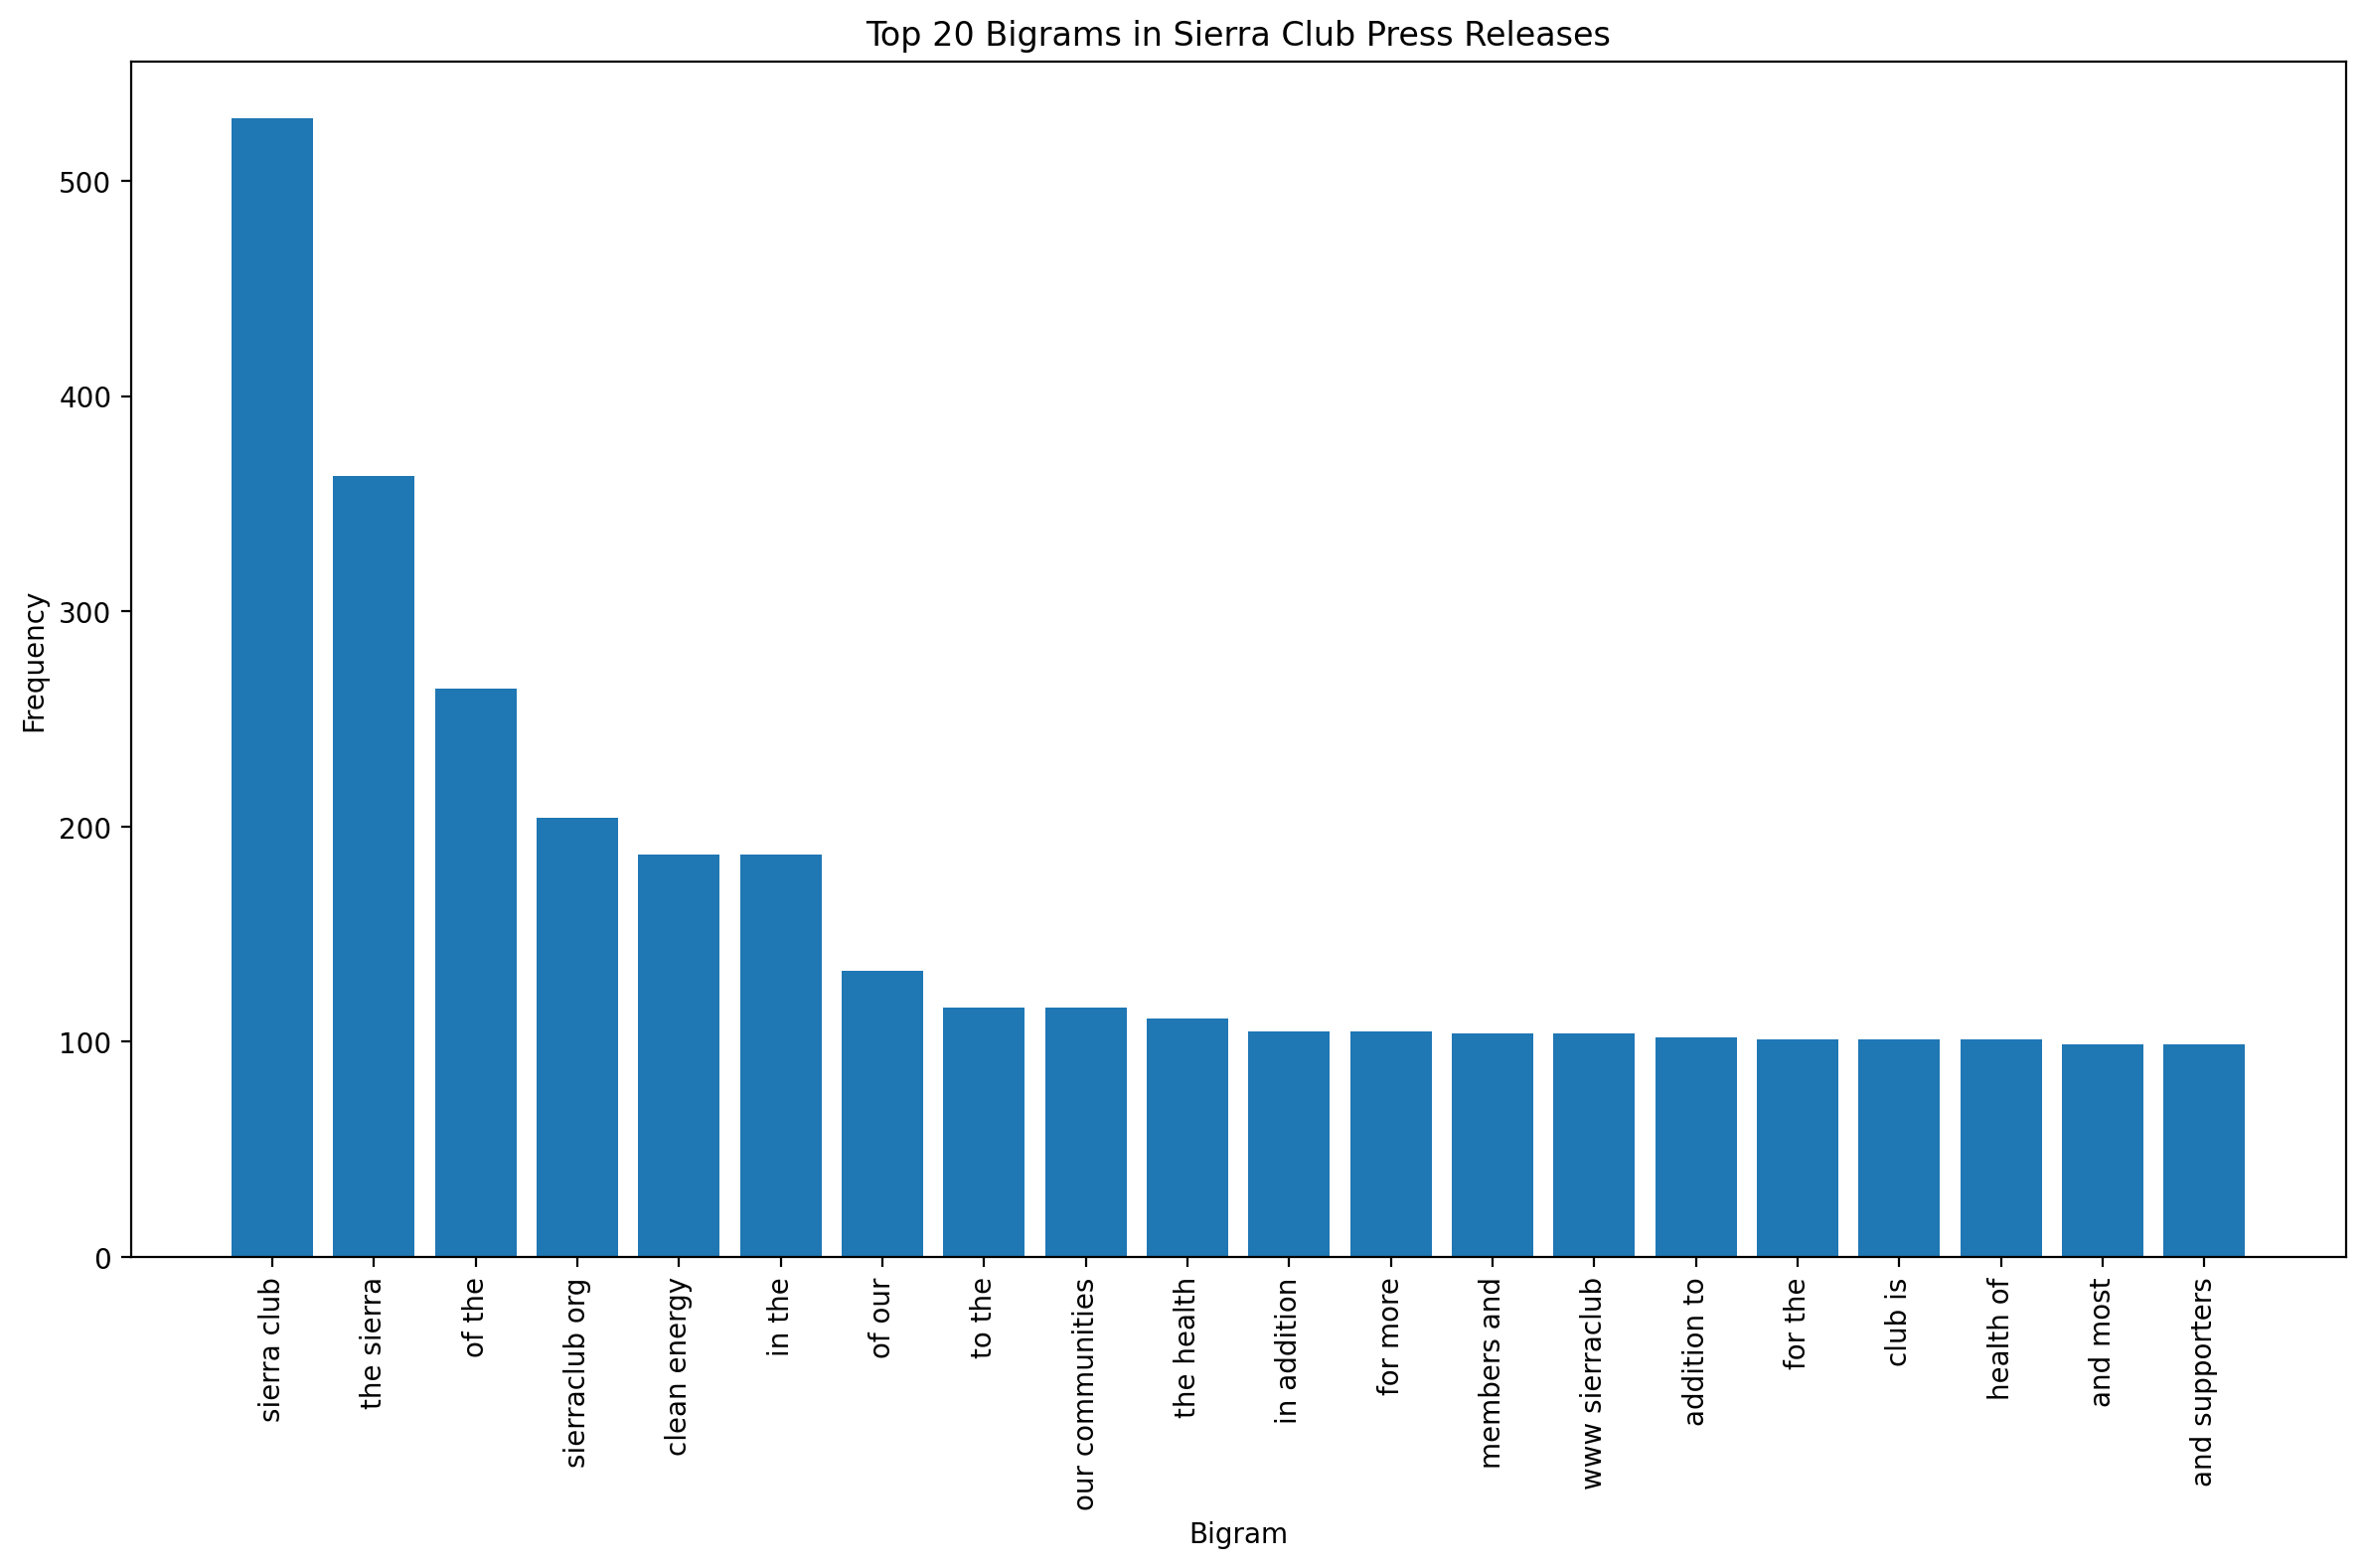

In [17]:
def get_top_n_bigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return words_freq[:n]


top_bigrams = get_top_n_bigram(merged_df["content"], n=20)

# Visualize top bigrams
plt.figure(figsize=(12, 8))
x, y = zip(*top_bigrams)
plt.bar(x, y)
plt.xticks(rotation=90)
plt.xlabel("Bigram")
plt.ylabel("Frequency")
plt.title("Top 20 Bigrams in Sierra Club Press Releases")
plt.tight_layout()
plt.show()

## 4. Sentiment Analysis Comparison

Compare the sentiment analysis results from the LLM-based few-shot learning approach with a traditional lexicon-based method.


Sentiment Analysis Comparison:
textblob_sentiment_category  Neutral  Positive
few_shot_sentiment                            
Negative                           7        52
Neutral                            0        11
Positive                           1        29


<Figure size 1000x600 with 0 Axes>

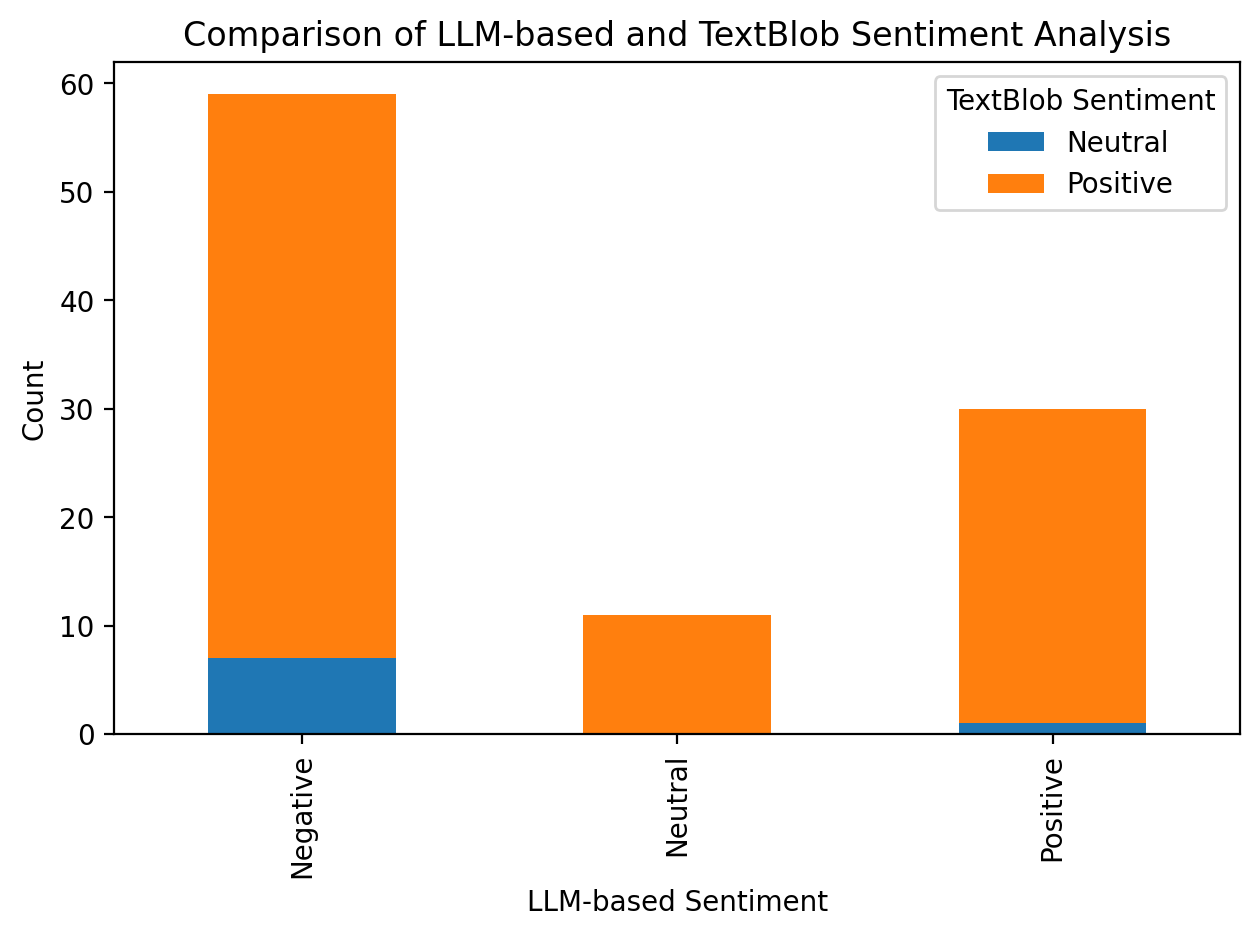

In [18]:
from textblob import TextBlob


def get_sentiment(text):
    return TextBlob(text).sentiment.polarity


merged_df["textblob_sentiment"] = merged_df["content"].apply(get_sentiment)


def categorize_sentiment(score):
    if score > 0.05:
        return "Positive"
    elif score < -0.05:
        return "Negative"
    else:
        return "Neutral"


merged_df["textblob_sentiment_category"] = merged_df["textblob_sentiment"].apply(
    categorize_sentiment
)

# Compare the results
comparison = pd.crosstab(
    merged_df["few_shot_sentiment"], merged_df["textblob_sentiment_category"]
)
print("Sentiment Analysis Comparison:")
print(comparison)

# Visualize the comparison
plt.figure(figsize=(10, 6))
comparison.plot(kind="bar", stacked=True)
plt.title("Comparison of LLM-based and TextBlob Sentiment Analysis")
plt.xlabel("LLM-based Sentiment")
plt.ylabel("Count")
plt.legend(title="TextBlob Sentiment")
plt.tight_layout()
plt.show()

## 5. Key Issue Extraction Evaluation

Evaluate the performance of the LLM-based key issue extraction by comparing it with a traditional keyword extraction method.


In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer


def extract_keywords(text, n=3):
    tfidf = TfidfVectorizer(max_features=100)
    response = tfidf.fit_transform([text])
    feature_array = np.array(tfidf.get_feature_names_out())
    tfidf_sorting = np.argsort(response.toarray()).flatten()[::-1]
    return "; ".join(feature_array[tfidf_sorting][:n])


merged_df["tfidf_keywords"] = merged_df["content"].apply(extract_keywords)

# Compare a sample of results
sample_comparison = merged_df[["key_issues", "tfidf_keywords"]].head(10)
print("Comparison of LLM-based and TF-IDF Keyword Extraction:")
print(sample_comparison)

Comparison of LLM-based and TF-IDF Keyword Extraction:
                                          key_issues    tfidf_keywords
0  energy efficiency; electricity usage reduction...  the; energy; and
1         water quality; contamination; strip mining       the; of; to
2  habitat destruction; environmental damage; flo...      and; the; of
3  Energy burdens; Historic discrimination; Disin...      the; of; and
4  oil and gas drilling in the Arctic; thermal co...      the; and; to
5  clear cutting land; destruction of Garcia Past...     the; and; rio
6      methane pollution; public lands; polluted air      the; and; to
7  fracked gas pipelines; tolling orders; eminent...      the; to; and
8  fossil fuel electricity generation; clean ener...  the; energy; and
9  air quality; noise pollution; environmental ju...      the; and; of


## 6. Analysis and Interpretation

Based on the results of these traditional NLP techniques, analyze and interpret the findings:

1. How do the traditional classification methods compare to the LLM-based zero-shot classification? Discuss the strengths and weaknesses of each approach.
2. What insights do the LDA topics provide about the main themes in Sierra Club press releases? How do these compare with the zero-shot classification results?
3. What patterns do you observe in the word co-occurrence analysis? How might these inform our understanding of environmental communication strategies?
4. Compare the sentiment analysis results from the LLM-based and lexicon-based methods. What are the implications of any differences for social science research on environmental advocacy?
5. Evaluate the effectiveness of the LLM-based key issue extraction compared to the TF-IDF method. What are the pros and cons of each approach for analyzing environmental communication?

## 7. Exercise

For your exercise, please complete the following tasks:

1. Implement a traditional NLP approach (e.g., rule-based or machine learning) to extract quotes from the press releases. Compare its performance with the LLM-based quote extraction you implemented in Lab 2.

2. Use a traditional NLP technique (e.g., pattern matching, named entity recognition) to identify organizations mentioned in the press releases. Compare these results with the key issues extracted by the LLM.

3. Apply a lexical diversity measure (e.g., type-token ratio or MTLD) to analyze the complexity of language used in the press releases. Investigate if there's any correlation between language complexity and the topics or sentiments of the releases.

4. Create a visualization that combines insights from both traditional NLP techniques and LLM-based analyses. For example, you could create a scatter plot of lexical diversity vs. sentiment, with points colored by the zero-shot classification topic.

5. Write a brief (300-350 words) comparative analysis of traditional NLP techniques and LLM-based approaches for analyzing environmental communication. Discuss the strengths, weaknesses, and potential complementarities of these methods in the context of social science research.

Submit your code, visualizations, and written analysis.
